In [ ]:
### node states ###
# 0 not infected
# 1 infected: incubation
# 2 infected: incubation
# 3 infected: spreading
# 4 infected: spreading
# 5 immune

In [ ]:
# generate cluster files
!python gencluster.py 100000 0.5 clust/cluster_nbrs_e5_sigma_0.5.clust clust/grid_nbrs_e5_sigma_0.5.clust clust/b_cluster_nbrs_e5_sigma_0.5.clust
!python gencluster.py 100000 0.25 clust/cluster_nbrs_e5_sigma_0.25.clust clust/grid_nbrs_e5_sigma_0.25.clust clust/b_cluster_nbrs_e5_sigma_0.25.clust
!python gencluster.py 100000 0.125 clust/cluster_nbrs_e5_sigma_0.125.clust clust/grid_nbrs_e5_sigma_0.125.clust clust/b_cluster_nbrs_e5_sigma_0.125.clust

In [1]:
import sys
import numpy as np
import random
import math
import time


class Sim:    
    def __init__(self):
        self.node_states = {}
        self.cluster_nbrs = {}
        self.grid_nbrs = {}
        self.b_cluster_nbrs = {}


    def read_cluster_files(self, cluster_nbrs_path, grid_nbrs_path, b_cluster_nbrs_path):
        print('read cluster files')
        self.node_states = {}
        
        self.cluster_nbrs = {}
        with open(cluster_nbrs_path) as f:
            for line in f:
                node, nbrs = line.split(':')
                node = int(node)
                nbrs = set(map(int, nbrs.split()))
                self.cluster_nbrs[node] = nbrs
                self.node_states[node] = 0

        self.grid_nbrs = {}
        with open(grid_nbrs_path) as f:
            for line in f:
                node, nbrs = line.split(':')
                node = int(node)
                nbrs = set(map(int, nbrs.split()))
                self.grid_nbrs[node] = nbrs

        self.b_cluster_nbrs = {}
        with open(b_cluster_nbrs_path) as f:
            for line in f:
                node, nbrs = line.split(':')
                node = int(node)
                nbrs = set(map(int, nbrs.split()))
                self.b_cluster_nbrs[node] = nbrs


    def spread_1(self, spreading_nodes, prob):
        for spreading_node in spreading_nodes:
            for nbr in self.cluster_nbrs[spreading_node]:
                if self.node_states[nbr] == 0:
                    if random.random() < prob:
                        self.node_states[nbr] = 1


    def spread_2(self, spreading_nodes, prob):
        inf_a_nodes = []
        for spreading_node in spreading_nodes:
            if spreading_node in self.grid_nbrs:
                for nbr in self.grid_nbrs[spreading_node]:
                    if self.node_states[nbr] == 0:
                        if random.random() < prob:
                            self.node_states[nbr] = 1
                            inf_a_nodes.append(nbr)
            if spreading_node in self.b_cluster_nbrs:
                for nbr in self.b_cluster_nbrs[spreading_node]:
                    if self.node_states[nbr] == 0:
                        if random.random() < prob:
                            self.node_states[nbr] = 1
        return inf_a_nodes


    def immunize_a_cluster_nbrs(self, inf_a_nodes, prob):
        for inf_a_node in inf_a_nodes:
            if random.random() < prob:
                for nbr in self.cluster_nbrs[inf_a_node]:
                    self.node_states[nbr] = 5

                    
    def run_sim(self, sim_iter, stage1_prob, stage2_prob, immunize_prob):
        num_start = int(2*math.log(len(self.node_states)))
        start_nodes = random.sample(self.node_states.keys(), num_start)
        for v in self.node_states:
            self.node_states[v] = 0
        for v in start_nodes:
            self.node_states[v] = 1

        print('n: {}'.format(len(self.node_states)))
        print('start nodes: {}'.format(len(start_nodes)))
        print('iters: {}'.format(sim_iter))
        print('probs: {} {} {}'.format(stage1_prob, stage2_prob, immunize_prob))
        x_rounds = []
        y_num_inf = []

        for rnd in range(sim_iter):
            inf_nodes = []
            spreading_nodes = []
            for v in self.node_states.keys():
                if self.node_states[v] >= 1 and self.node_states[v] <= 4:
                    inf_nodes.append(v)
                    if self.node_states[v] >= 3 and self.node_states[v] <= 4:
                        spreading_nodes.append(v)

            self.spread_1(spreading_nodes, stage1_prob)
            inf_a_nodes = self.spread_2(spreading_nodes, stage2_prob)
            self.immunize_a_cluster_nbrs(inf_a_nodes, immunize_prob)

            for inf_node in inf_nodes:
                self.node_states[inf_node] += 1

            num_inf = sum([1 for v in self.node_states.keys() if self.node_states[v] > 0])
            x_rounds.append(rnd)
            y_num_inf.append(num_inf)

        print('infected nodes: {}'.format(num_inf))
        print()
        return x_rounds, y_num_inf


In [2]:
cluster_nbrs_path = 'clust/cluster_nbrs_e5_sigma_{}.clust'
grid_nbrs_path = 'clust/grid_nbrs_e5_sigma_{}.clust'
b_cluster_nbrs_path = 'clust/b_cluster_nbrs_e5_sigma_{}.clust'

sim_iter = 200
sigmas = [0.5, 0.25, 0.125]
stage1_prob = 0.3
stage2_probs = [0.2, 0.16, 0.14, 0.12, 0.1, 0.08]
immunize_probs = [0.0, 0.25, 1/3, 0.5]

results = {}
for sigma in sigmas:
    results[sigma] = {}
    for immunize_prob in immunize_probs:
        results[sigma][immunize_prob] = {}

sim = Sim()
starttime = time.time()
for sigma in sigmas:
    print('sigma: {}'.format(sigma))
    sim.read_cluster_files(cluster_nbrs_path.format(sigma), grid_nbrs_path.format(sigma), b_cluster_nbrs_path.format(sigma))
    for stage2_prob in stage2_probs:
        for immunize_prob in immunize_probs:
            x, y = sim.run_sim(sim_iter, stage1_prob, stage2_prob, immunize_prob)
            results[sigma][immunize_prob][stage2_prob] = (x, y)
print('runtime: {}s'.format(time.time() - starttime))

sigma: 0.5
read cluster files
n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.2 0.5
infected nodes: 189901

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.2 0.3333333333333333
infected nodes: 194359

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.2 0.25
infected nodes: 195638

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.2 0.0
infected nodes: 197211

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.16 0.5
infected nodes: 171297

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.16 0.3333333333333333
infected nodes: 178677

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.16 0.25
infected nodes: 180651

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.16 0.0
infected nodes: 185070

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.14 0.5
infected nodes: 154457

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.14 0.3333333333333333
infected nodes: 165514

n: 238640
start nodes: 24
iters: 200
probs: 0.3 0.14 0.25
infected nodes: 169187

n: 238640
start nodes: 24
iters: 20

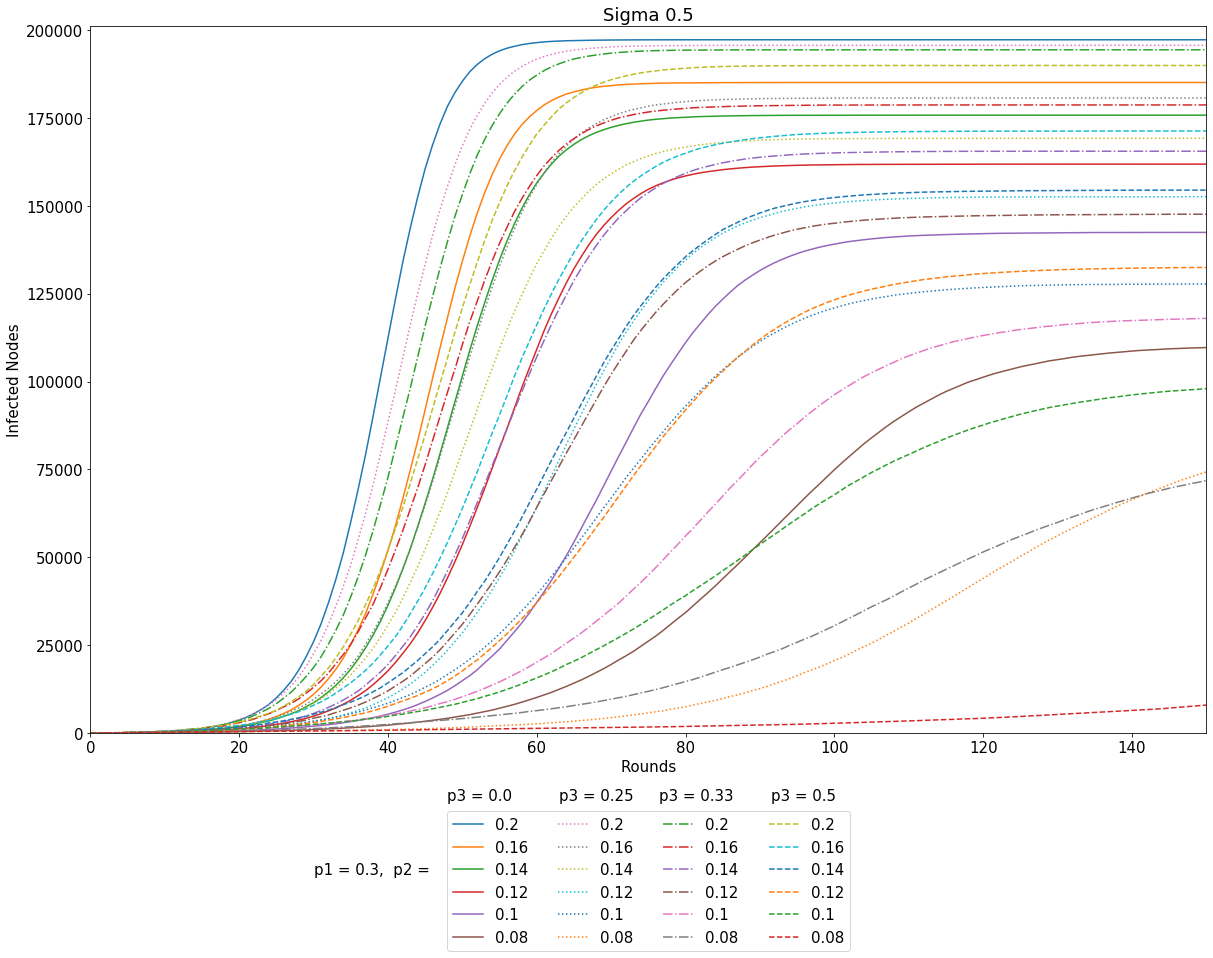

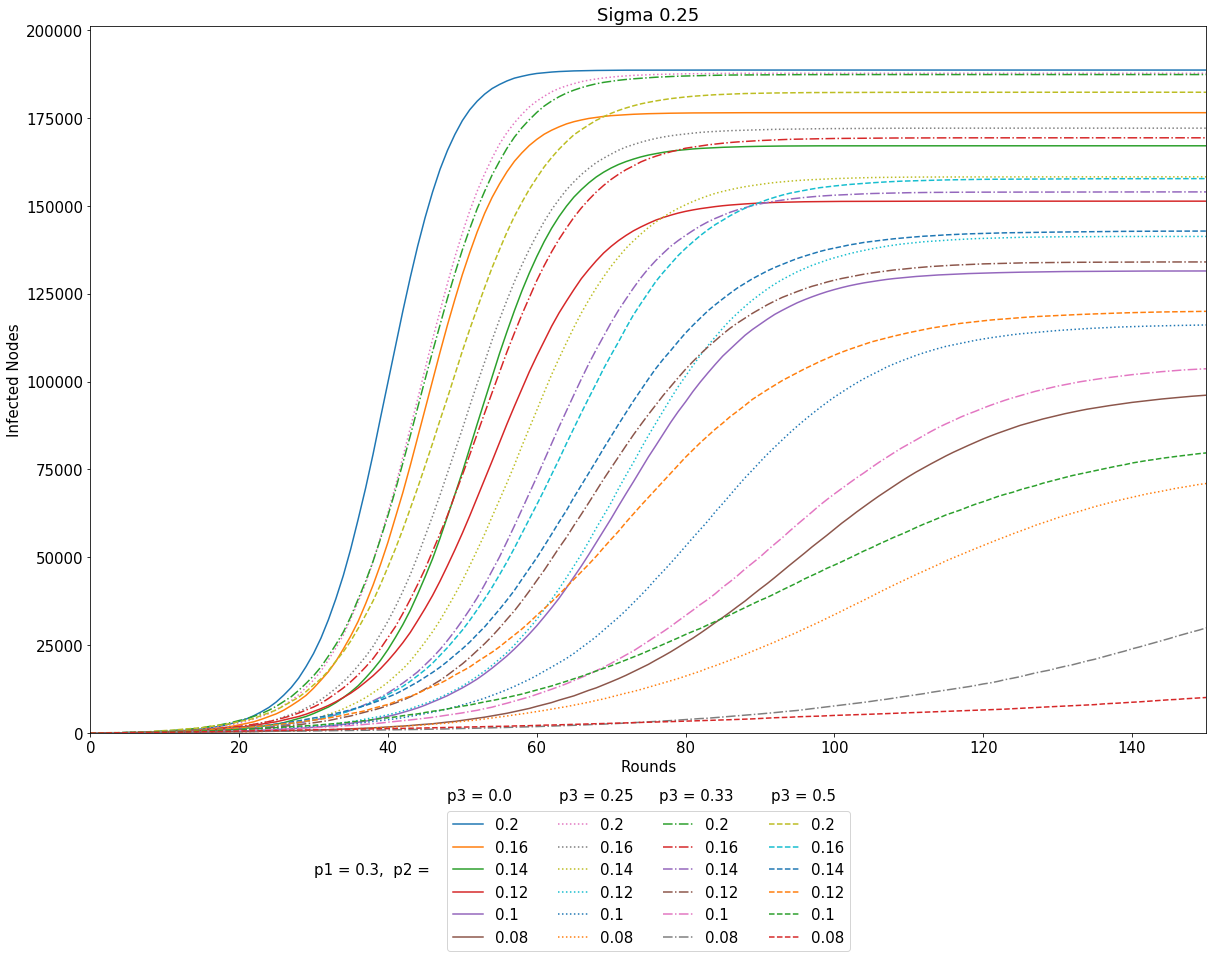

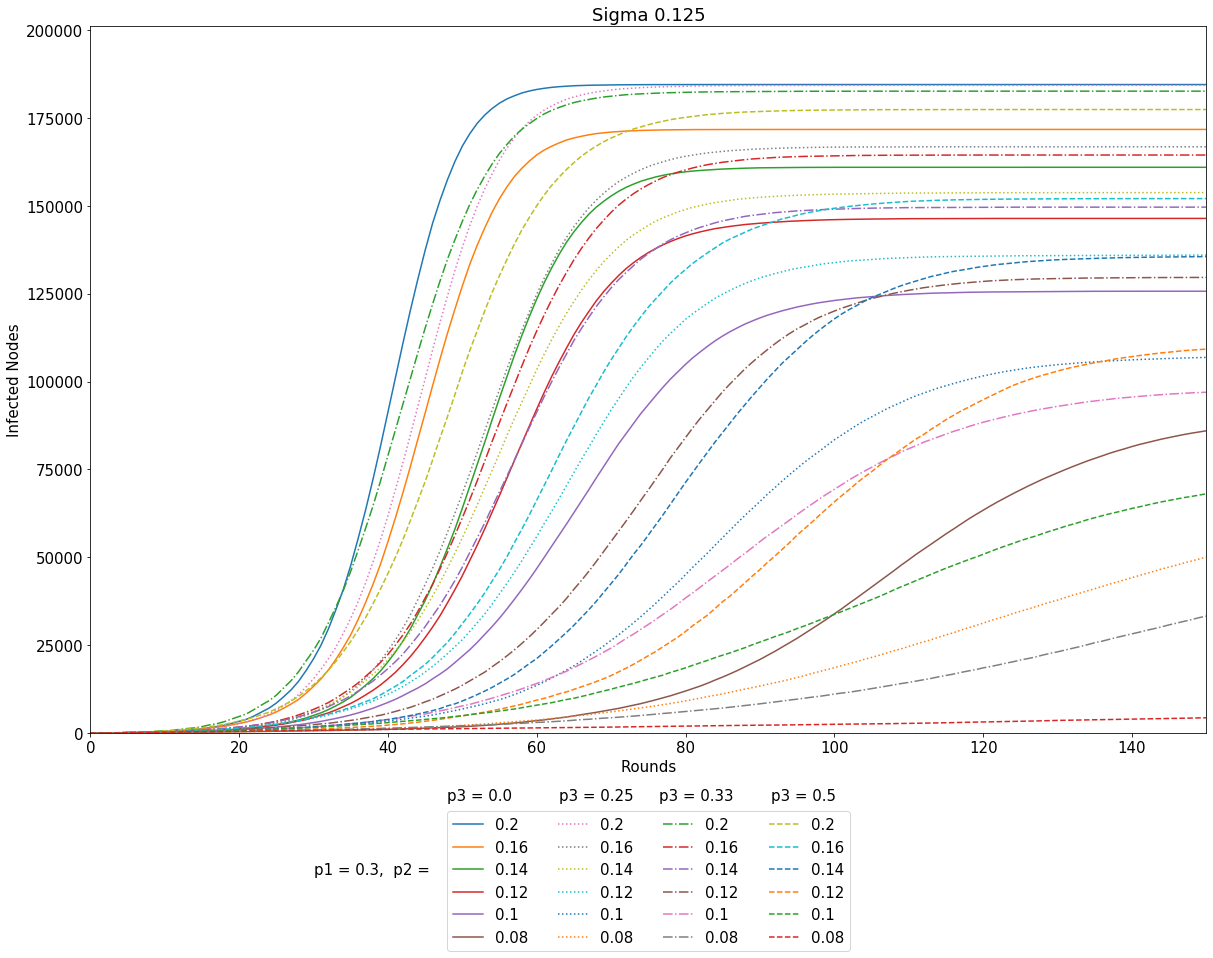

In [40]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
linestyles = ['solid', 'dotted', 'dashdot', 'dashed']

for sigma in sigmas:
    fig, axs = plt.subplots(figsize=(20,13))
    axs.set_ylim(top=201000)
    axs.set_xlim(0, 150)
    for i, immunize_prob in enumerate(immunize_probs):
        for stage2_prob in stage2_probs:
            axs.plot(results[sigma][immunize_prob][stage2_prob][0], results[sigma][immunize_prob][stage2_prob][1], label=stage2_prob, linestyle=linestyles[i % len(linestyles)])
    axs.set_title('Sigma {}'.format(sigma))
    axs.set_xlabel('Rounds')
    axs.set_ylabel('Infected Nodes')
    axs.text(0.2, -0.2, 'p1 = {},  p2 ='.format(stage1_prob), transform=axs.transAxes)
    axs.text(0.32, -0.095, 'p3 = {}'.format(immunize_probs[0]), transform=axs.transAxes)
    axs.text(0.42, -0.095, 'p3 = {}'.format(immunize_probs[1]), transform=axs.transAxes)
    axs.text(0.51, -0.095, 'p3 = {:.2f}'.format(immunize_probs[2]), transform=axs.transAxes)
    axs.text(0.61, -0.095, 'p3 = {}'.format(immunize_probs[3]), transform=axs.transAxes)
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

## Old

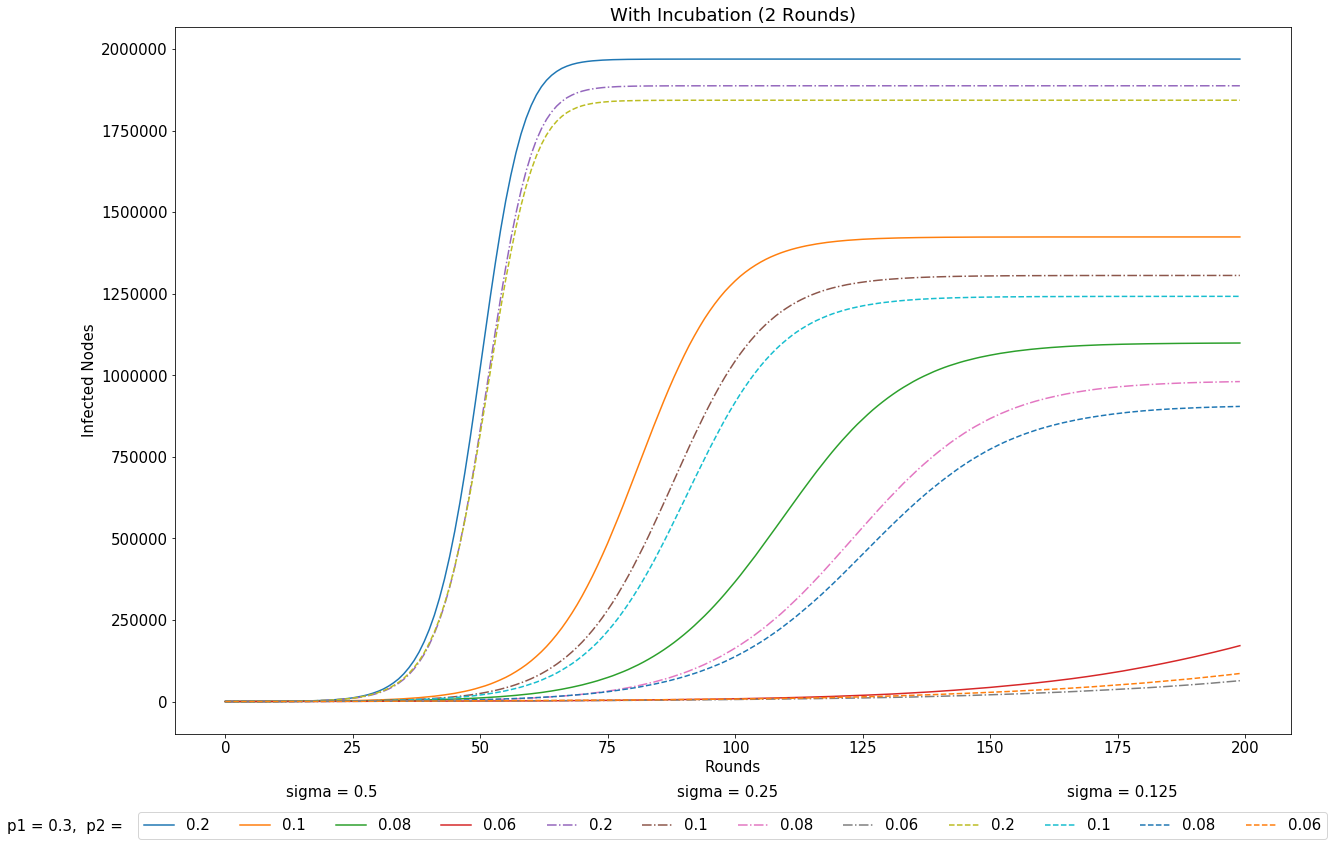

In [65]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(figsize=(20,13))
for i in results_5.keys():
    axs.plot(results_5[i][0], results_5[i][1], label=i)
for i in results_25.keys():
    axs.plot(results_25[i][0], results_25[i][1], label=i, linestyle='dashdot')
for i in results_125.keys():
    axs.plot(results_125[i][0], results_125[i][1], label=i, linestyle='dashed')
axs.set_title('With Incubation (2 Rounds)')
axs.set_xlabel('Rounds')
axs.set_ylabel('Infected Nodes')
axs.text(-0.15, -0.138, 'p1 = 0.3,  p2 =', transform=axs.transAxes)
axs.text(0.1, -0.09, 'sigma = 0.5', transform=axs.transAxes)
axs.text(0.45, -0.09, 'sigma = 0.25', transform=axs.transAxes)
axs.text(0.8, -0.09, 'sigma = 0.125', transform=axs.transAxes)
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=16)
